## Get data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

sns.set_style('darkgrid')
sns.set(font_scale=1.3)

In [2]:
# read file
USERS_INFO_PATH = "train_data/merged.csv"
users_data_initial = pd.read_csv(USERS_INFO_PATH, sep=';', encoding='windows-1251')
users_data_initial.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12320\821584657.py:3: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  users_data_initial = pd.read_csv(USERS_INFO_PATH, sep=';', encoding='windows-1251')


,accnt_id,Возврат выплаченных сумм (ОПС) summary,Восполнение (ОПС) summary,Закрытие договора ОПС summary,Компенсация(ОПС) summary,Корректировка записей регистров (ОПС) summary,Назначение пенсии (ОПС) summary,Начисление (ОПС) summary,Начисление пенсии (ОПС) summary,Перевод в резерв Фонда (ОПС) summary,...,dstrct,city,sttlmnt,pstl_code,okato,phn,email,lk,assgn_npo,assgn_ops
0,0x00003A37F46E104EB1AB513510DC1C79,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,NaN,МЫСКИ Г,NaN,652840,3.200000e+10,нет,нет,нет,нет,нет
1,0x00005C5B81A6B34C93DD254536771BB6,0.0,0.02,0.0,0.0,-0.01,0.0,0.0,0.0,0.0,...,NaN,МУРМАНСК Г,NaN,183038,4.700000e+10,нет,нет,да,нет,нет
2,0x000068BD0A374844BBD3F76E903BF0EE,0.0,30.22,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,NaN,ОКТЯБРЬСК Г,NaN,445240,3.600000e+10,нет,нет,нет,нет,нет
3,0x0000BE901FB8EE408BFF1CCA90A954B6,0.0,19.47,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,NaN,ЛЕСОЗАВОДСК Г,NaN,692060,5.000000e+09,нет,нет,нет,нет,нет
4,0x0000DEB99BDBE74D8298A7772971F4E5,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,NaN,КАЗАНЬ Г,NaN,420078,9.200000e+10,нет,нет,нет,нет,нет


## Clear Data

In [6]:
# data frame for experiments and analize
users_data = users_data_initial.copy()
users_data.shape

(532825, 57)

### add macroeconomic factors

In [9]:
# get regions from our db to compare it with user df
reg_df = users_data["rgn"].unique().tolist()

connection = sqlite3.connect('Information.sqlite')
cursor = connection.cursor()
cursor.execute("""SELECT name, population, average_lifespan, average_salary from regions""")
result_data = cursor.fetchall()

reg_name = [x[0] for x in result_data]
reg_population = [x[1] for x in result_data]
reg_lifespan = [x[2] for x in result_data]
reg_salary = [x[3] for x in result_data]
connection.close()

In [11]:
# function to make dict regions in user data -- it features 
def make_regions_dict(reg_df, reg_db, reg_population, reg_lifespan, reg_salary):
    """
    :param reg_df:
    :param reg_db:
    :param reg_population:
    :param reg_lifespan:
    :param reg_salary:
    :return: regions dict
    """
    reg_dict = {}

    # iterate by regions in user data
    for reg in reg_df:
        description = {
            'popularity': None,
            'lifespan': None,
            'salary': None
        }

        # iterate by database regions
        n = len(reg_db)
        for i in range(n):

            if type(reg) != str or type(reg_db[i]) != str:
                break

            # find similar regions
            if len(reg.lstrip()) > 5 and len(reg_db[i].lstrip()) > 5:
                if reg_db[i].lstrip().lower()[:5] == reg.lstrip().lower()[:5]:
                    description['popularity'] = reg_population[i]
                    description['lifespan'] = reg_lifespan[i]
                    description['salary'] = reg_salary[i]
                    break
        # if not founded
        if not description:
            description['popularity'] = sum(reg_population) / n
            description['lifespan'] = sum(reg_lifespan) / n
            description['salary'] = sum(reg_salary) / n
        reg_dict[reg] = description
    # return
    return reg_dict

In [16]:
# fill 
reg_dict = make_regions_dict(reg_df, reg_name, reg_population, reg_lifespan, reg_salary)
users_data['rgn_popl'] = users_data['rgn'].apply(lambda x: reg_dict[x]['popularity'])
users_data['rgn_lfspn'] = users_data['rgn'].apply(lambda x: reg_dict[x]['lifespan'])
users_data['rgn_sal'] = users_data['rgn'].apply(lambda x: reg_dict[x]['salary'])

### analize columns

In [19]:
# drop columns
users_data = users_data.drop(columns=["brth_yr", "pstl_code", "okato", "brth_plc", "dstrct", "city", "sttlmnt", "slctn_nmbr"]) #slctn_nmbr?
users_data = users_data.drop(columns=["accnt_status", "cprtn_prd_d", "prsnt_age"])

In [21]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532825 entries, 0 to 532824
Data columns (total 49 columns):
 #   Column                                                                         Non-Null Count   Dtype  
---  ------                                                                         --------------   -----  
 0   accnt_id                                                                       532825 non-null  object 
 1   Возврат выплаченных сумм (ОПС) summary                                         532825 non-null  float64
 2   Восполнение (ОПС) summary                                                      532825 non-null  float64
 3   Закрытие договора ОПС summary                                                  532825 non-null  float64
 4   Компенсация(ОПС) summary                                                       532825 non-null  float64
 5   Корректировка записей регистров (ОПС) summary                                  532825 non-null  float64
 6   Назначение п

In [23]:
# features structure
id_fetures = ["clnt_id", "accnt_id"]
num_features = ["pnsn_age", "rgn_popl", "rgn_lfspn", "rgn_sal"]
bool_features = ["phn", "email", "lk", "assgn_npo", "assgn_ops"]
class_features = ["gndr", "addrss_type"]
date_features = ["accnt_bgn_date", "min_oprtn_date", "max_oprtn_date"]
label_features = ["erly_pnsn_flg"]
text_features = ["rgn", "prvs_npf"]

num_merge_features = ['Возврат выплаченных сумм (ОПС) summary',
 'Восполнение (ОПС) summary',
 'Закрытие договора ОПС summary',
 'Компенсация(ОПС) summary',
 'Корректировка записей регистров (ОПС) summary',
 'Назначение пенсии (ОПС) summary',
 'Начисление (ОПС) summary',
 'Начисление пенсии (ОПС) summary',
 'Перевод между счетами ОПС summary',
 'Поступление взносов ОПС summary',
 'Приостановление/возобновление/прекращение выплат пенсии (ОПС) summary',
 'Распределение ИД ОПС summary',
 'Решение о единовременной выплате (ОПС) summary',
 'Возврат выплаченных сумм (ОПС)_exists',
 'Восполнение (ОПС)_exists',
 'Компенсация(ОПС)_exists',
 'Корректировка записей регистров (ОПС)_exists',
 'Назначение пенсии (ОПС)_exists',
 'Начисление (ОПС)_exists',
 'Начисление пенсии (ОПС)_exists',
 'Поступление взносов ОПС_exists',
 'Распределение ИД ОПС_exists',
 'Решение о единовременной выплате (ОПС)_exists']

### remove unsignificant features

In [26]:
def print_features_distribution(gb_features):
    """
    print min / max features disctibutions
    """
    for gb in gb_features:
        print(gb + ":")
        gb_list = users_data.groupby([gb]).count().iloc[:, 0].to_list()
        if len(gb_list) > 50:
            gb_list = "Too many features"
        else:
            print(users_data[gb].unique())
        print(gb_list)
        print('_______________________________________')

In [28]:
print_features_distribution(bool_features + class_features)
print_features_distribution(num_merge_features)

phn:
['нет' 'да']
[4435, 528390]
_______________________________________
email:
['нет' 'да']
[430, 532395]
_______________________________________
lk:
['нет' 'да']
[84388, 448437]
_______________________________________
assgn_npo:
['нет' 'да']
[117, 532708]
_______________________________________
assgn_ops:
['нет' 'да']
[3355, 529470]
_______________________________________
gndr:
['ж' 'м']
[343320, 189505]
_______________________________________
addrss_type:
['Адрес по прописке' 'Адрес места жительства' 'Адрес для информирования'
 'Адрес за пределами РФ']
[256, 3, 437883, 94683]
_______________________________________
Возврат выплаченных сумм (ОПС) summary:
Too many features
_______________________________________
Восполнение (ОПС) summary:
Too many features
_______________________________________
Закрытие договора ОПС summary:
Too many features
_______________________________________
Компенсация(ОПС) summary:
Too many features
_______________________________________
Корректировка запи

In [29]:
# drop unsignificunt ones
users_data = users_data.drop(columns=['Передача СПН в другой фонд по Уведомлениям ПФР о разделении ИЛС (ОПС)_exists', 
                         'Приостановление/возобновление/прекращение выплат пенсии (ОПС)_exists',
                         'Перевод в резерв Фонда (ОПС)_exists',
                         'Перевод между счетами ОПС_exists',
                         'Закрытие договора ОПС_exists',
                         'Перевод в резерв Фонда (ОПС) summary',
                         'Передача СПН в другой фонд по Уведомлениям ПФР о разделении ИЛС (ОПС) summary'])

### remove na

In [33]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532825 entries, 0 to 532824
Data columns (total 42 columns):
 #   Column                                                                 Non-Null Count   Dtype  
---  ------                                                                 --------------   -----  
 0   accnt_id                                                               532825 non-null  object 
 1   Возврат выплаченных сумм (ОПС) summary                                 532825 non-null  float64
 2   Восполнение (ОПС) summary                                              532825 non-null  float64
 3   Закрытие договора ОПС summary                                          532825 non-null  float64
 4   Компенсация(ОПС) summary                                               532825 non-null  float64
 5   Корректировка записей регистров (ОПС) summary                          532825 non-null  float64
 6   Назначение пенсии (ОПС) summary                                        53282

In [35]:
users_data["prvs_npf"] = users_data["prvs_npf"].fillna("None")

In [37]:
users_data = users_data.dropna()

### normalize

In [40]:
def normalize(df, col, type='std'):
    """
    :param df:
    :param col: column of df
    :param type: type of normalization std / log / minmax
    :change: dataframe nums feature to normalized view
    """
    if type=='std':
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    elif type == 'log':
        df[col] = np.sign(df[col]) * np.log(np.abs(df[col]) + 1)
    elif type == 'minmax':
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# normalize num features
for nf in num_features + num_merge_features:
    min_nf = users_data[nf].min()
    max_nf = users_data[nf].max()
    delta = max_nf - min_nf

    # if delta too large use log normalization, minmax else
    if delta > 1000:
        normalize(users_data, nf, type="log")
    else:
        normalize(users_data, nf, type="minmax")
    min_nf = users_data[nf].min()
    max_nf = users_data[nf].max()

### drop releases ""

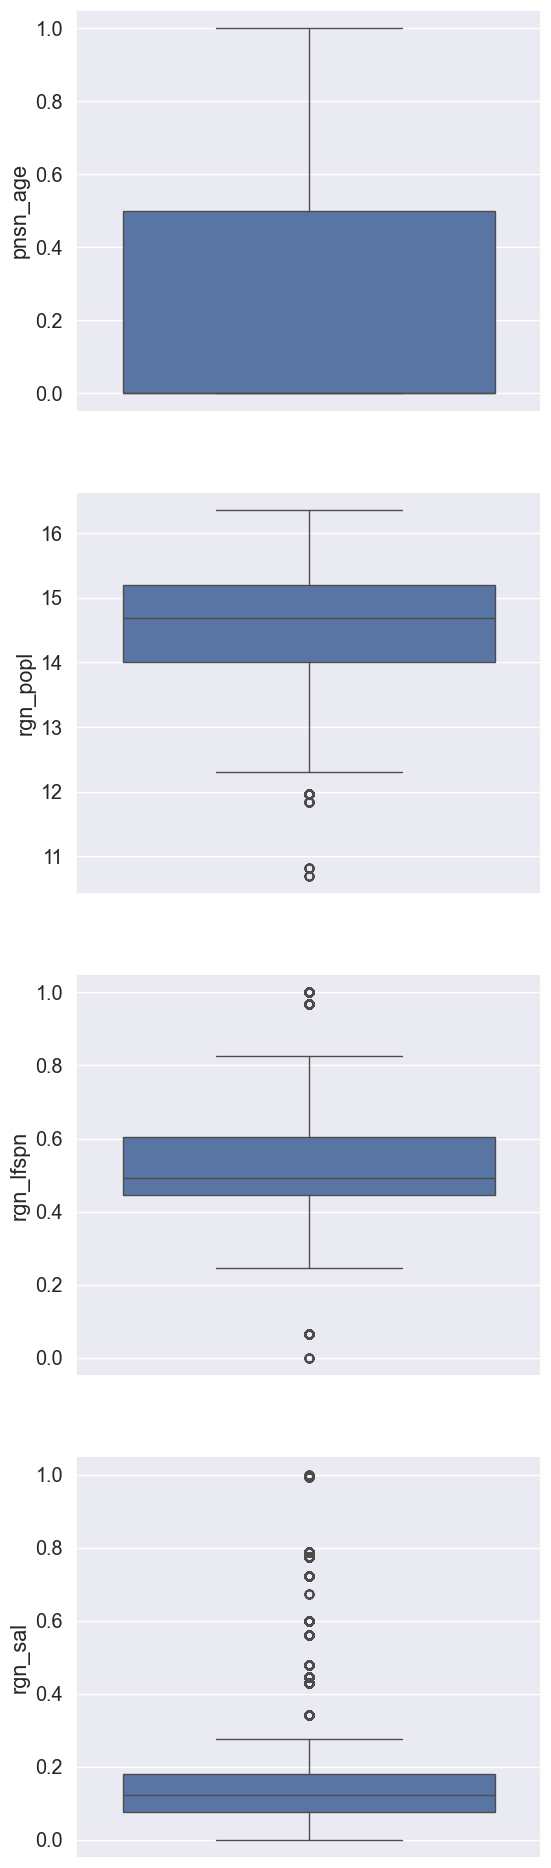

In [43]:
# looking at emissions
n = len(num_features)
fig, axes = plt.subplots(n, 1, figsize=(6, 6*n))

for i, nf in enumerate(num_features):
    sns.boxplot(users_data[nf], ax=axes[i])

In [44]:
# in our task this is unsignificunt releases

### fill class and bool features

In [46]:
# fill bool features
for bf in bool_features:
    users_data[bf] = users_data[bf].apply(lambda x: 0 if x == "нет" else 1)

In [47]:
# fill cat features
for cf in class_features:
    lst = users_data[cf].unique().tolist()
    print(cf, ":\n- ", lst)
    users_data[cf] = users_data[cf].apply(lambda x: lst.index(x) + 1)
    print()

gndr :
-  ['ж', 'м']

addrss_type :
-  ['Адрес по прописке', 'Адрес места жительства', 'Адрес для информирования']



## Analize data

In [53]:
# split by key value and extract data for analize with equal distribution by key value
users_0 = users_data[(users_data["erly_pnsn_flg"]==0)]
users_1 = users_data[(users_data["erly_pnsn_flg"]==1)]
users_data_for_analize = pd.concat([users_0[:5000], users_1[:5000]])

In [55]:
num_data = users_data_for_analize[num_features + bool_features + class_features + label_features]

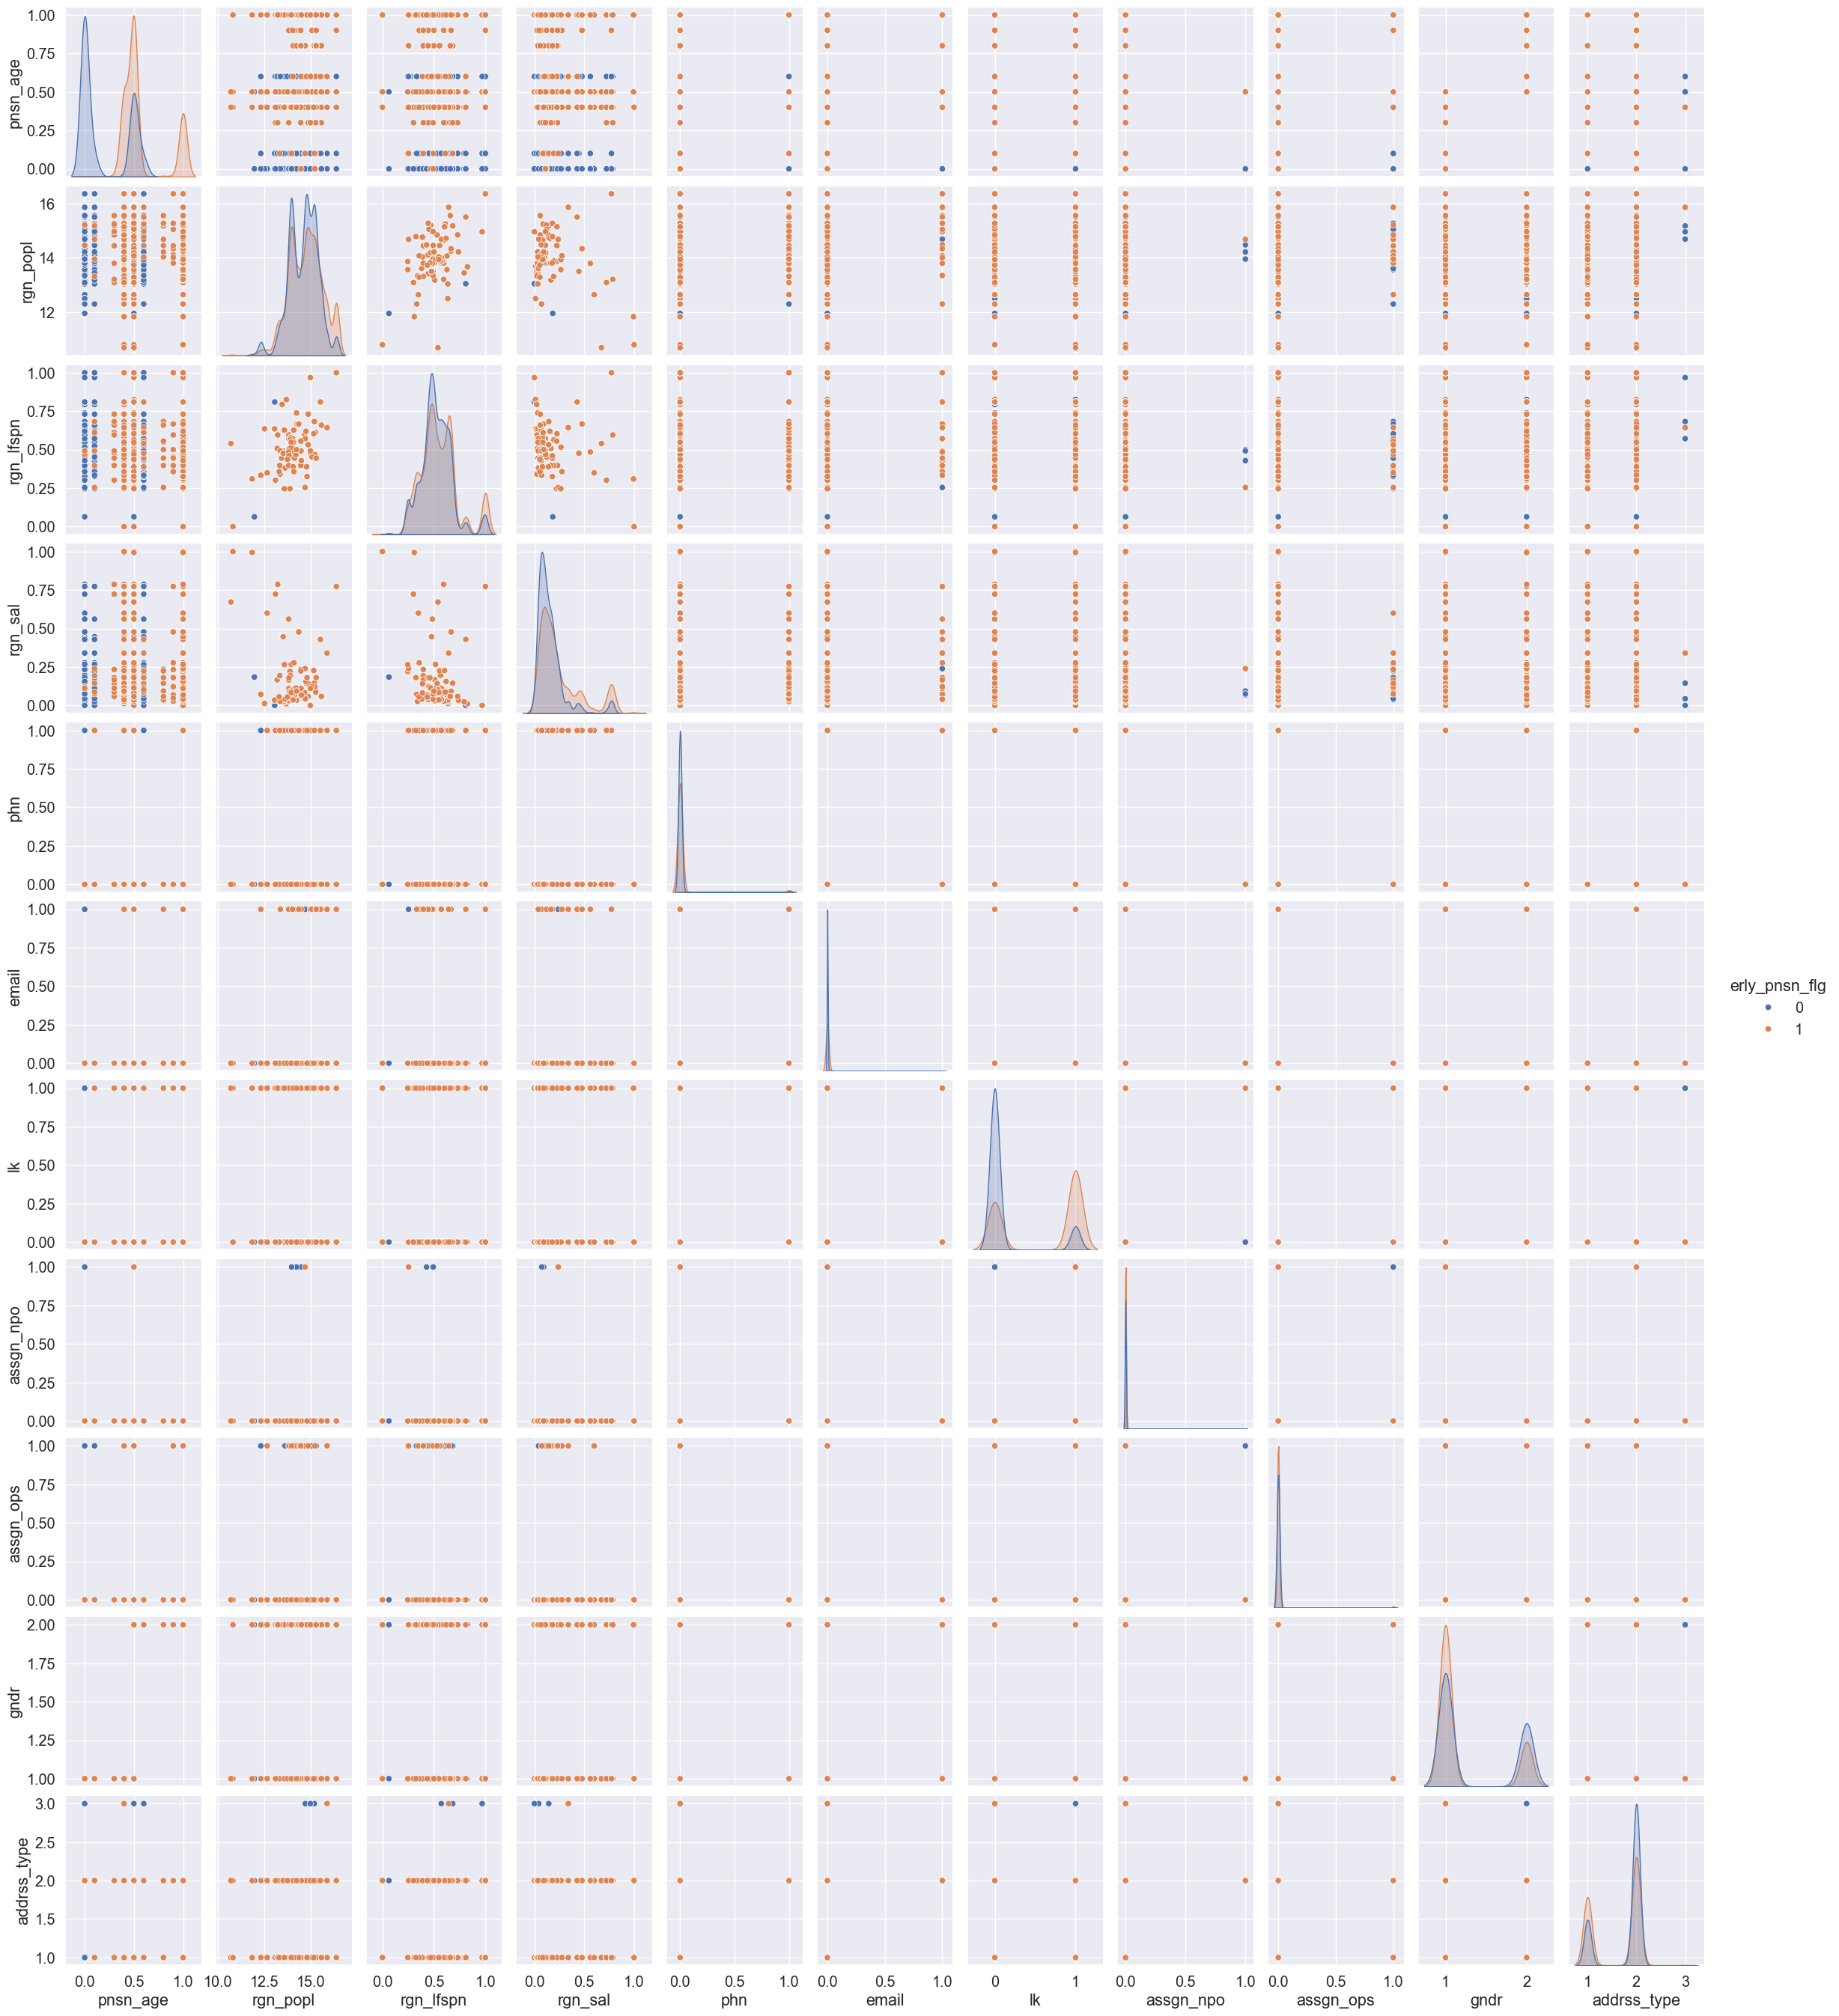

In [59]:
# distribution pairplot by key value
sns.pairplot(
    data=num_data, 
    aspect=.85,
    hue=label_features[0])

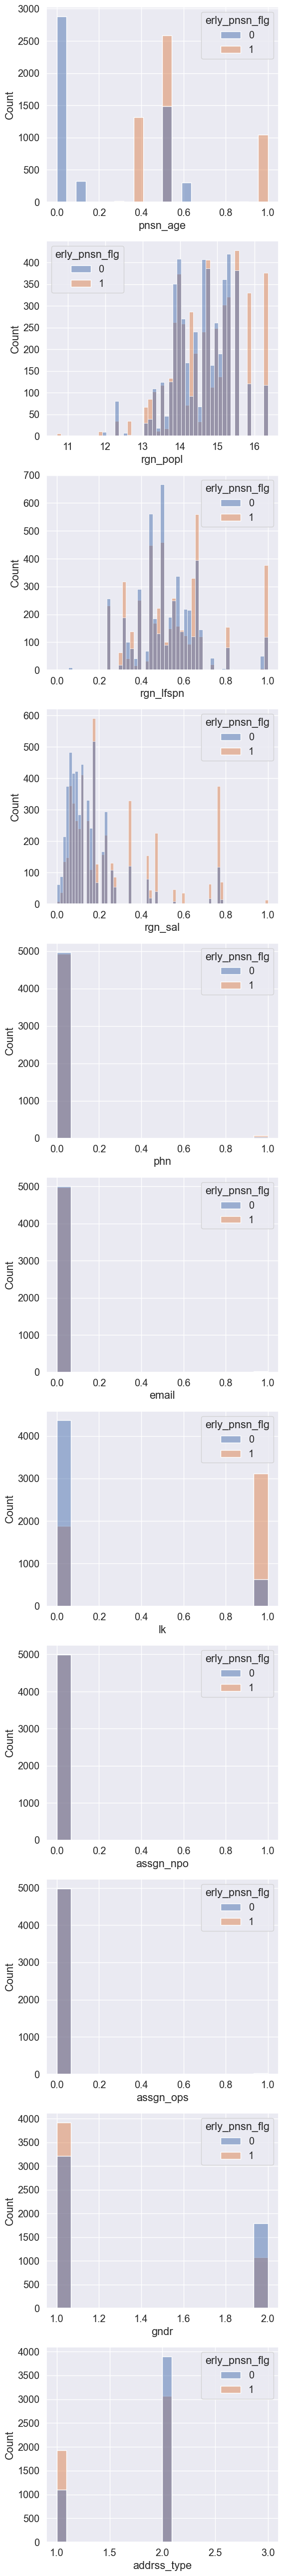

In [60]:
# distribution hisplot by key value
n = len(num_features + bool_features + class_features)

fig, axes = plt.subplots(n, 1, figsize=(6, 6*n))

for i, f in enumerate(num_features + bool_features + class_features):
    sns.histplot(num_data, x=f, hue=label_features[0], ax=axes[i])

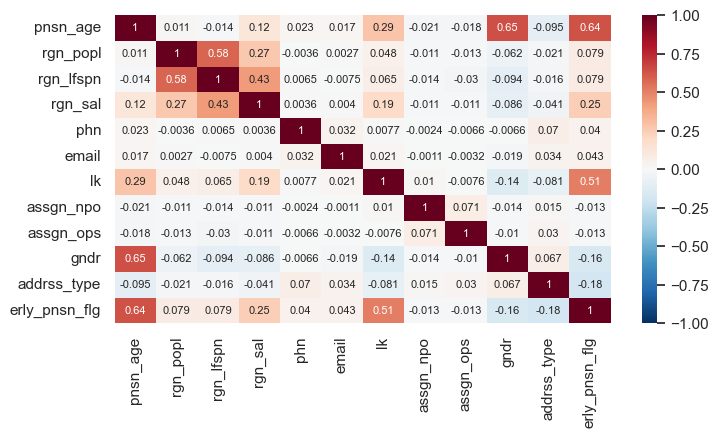

In [61]:
sns.set(font_scale=1)
plt.figure(figsize=(8,4))
sns.heatmap(
    num_data.corr(),        
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, # рисует значения внутри 
    annot_kws={"size":8},
    vmin=-1, vmax=1); # указывает начало цветовых кодов от -1 до 1.